In [1]:
# toggle pathing
drive_path = '/content/drive/MyDrive/UCLA Fall 2024/[Shared] CS 260D Large Scale Machine Learning/Final Project'
# drive_path = '/content/drive/MyDrive/[Shared] CS 260D Large Scale Machine Learning/Final Project'
data_path = rf'{drive_path}/data'

In [2]:
#this allows reimported py source files to be reloaded
%load_ext autoreload
%autoreload 2

# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt
import os
import sys

# Optionally, mount Google Drive if you want to save the data to Google Drive for persistence
# Uncomment the following lines if you'd like to save to Google Drive
from google.colab import drive
# drive.mount('/content/drive')
# data_path = '/content/drive/My Drive/Colab Notebooks/data'
drive.mount('/content/drive', force_remount=True)


sys.path.append(drive_path) # Define the path in the Shared Drive

# Otherwise, define a local path in the current Colab working directory
# data_path = './data'

# Check for GPU support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Ensure the local 'data' directory exists
os.makedirs(data_path, exist_ok=True)

# Download the MNIST dataset to the specified data path
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root=data_path, train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=2**8, shuffle=True)

Mounted at /content/drive
Using device: cuda


### Find size of desired subset

In [3]:
############################################
# Warning, this takes a few minutes to run
############################################
# Import necessary libraries
import pickle
import gzip
import os

train_dataset = datasets.MNIST(root=data_path, train=True, transform=transform, download=True)
sample_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# unpack a bunch of examples
size_test_images = []
size_test_labels = []
for images, label_batch in sample_loader:
    for image in images:
      size_test_images.append(image)
    for label in label_batch:
      size_test_labels.append(label)
    # break

k = 150 # starting point just for visualizing, this takes a while to run
serialized_size = 0
compressed_size = 0
x = []
y_comp = []
y_uncomp = []

while compressed_size < 3: # size in MB
  sset = (size_test_labels[:k], size_test_images[:k]) # choose sset above
  # Serialize the data with gzip compression to reduce size
  serialized_data = pickle.dumps(sset)
  compressed_data = gzip.compress(serialized_data)

  # Calculate the size of the compressed serialized data
  serialized_size = len(serialized_data) / (1024 * 1024)  # Convert bytes to MB
  compressed_size = len(compressed_data) / (1024 * 1024)  # Convert bytes to MB
  x.append(k)

  y_uncomp.append(serialized_size)
  y_comp.append(compressed_size)# y_comp.append(compressed_size)

  # Calculate total size of MNIST dataset on disk
  # def get_folder_size(path):
  #     total_size = 0
  #     for dirpath, dirnames, filenames in os.walk(path):
  #         for f in filenames:
  #             fp = os.path.join(dirpath, f)
  #             total_size += os.path.getsize(fp)
  #     return total_size / (1024 * 1024)  # Convert bytes to MB

  # print(f"Size of subset:\t\t k={k}, {serialized_size:.2f} MB")
  # print(f"Size of compressed sset: k={k}, {compressed_size:.2f} MB")
  # print('===========')
  k +=10


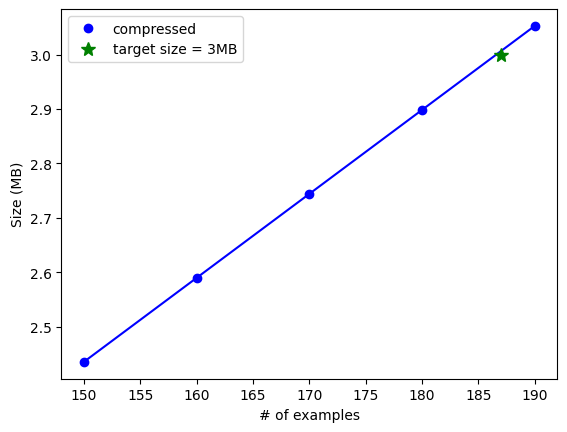

In [4]:
from scipy import stats
import numpy as np
# Now we have a linear regression for dataset size vs # of examples to extrapolate from
slope_comp, intercept_comp, r_comp, p_comp, std_err_comp = stats.linregress(x, y_comp)
plt.plot(x, y_comp, 'bo', label='compressed')
plt.plot(x, np.multiply(slope_comp,x) + intercept_comp, 'b-')

# slope_uncomp, intercept_uncomp, r_uncomp, p_uncomp, std_err_uncomp = stats.linregress(x, y_uncomp)
# plt.plot(x, y_uncomp, 'ro', label='uncompressed')
# plt.plot(x, np.multiply(slope_uncomp,x) + intercept_uncomp, 'r-')

target_size = 3 # MB
k_examples = round((target_size - intercept_comp)/slope_comp) # define subset size to extract

plt.plot(k_examples, target_size, 'g*', markersize=10, label=f'target size = {target_size}MB')

plt.xlabel('# of examples')
plt.ylabel('Size (MB)')
plt.legend()
plt.show()



# Random Subset Selection

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
class ReconstructedMNISTDataset(Dataset):
    def __init__(self, images, labels):
        """
        Args:
            images (list of Tensors): List of reconstructed images as PyTorch Tensors.
            labels (list of int): List of corresponding labels for each image.
        """
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get image and label by index
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

In [18]:
train_dataset = datasets.MNIST(root=data_path, train=True, transform=transform, download=True)
sample_loader = DataLoader(train_dataset, batch_size=60000, shuffle=True)
for batch, (images, labels) in enumerate(sample_loader):
  images = images.to(device)
  labels = labels.to(device)
  break

indices = torch.randperm(len(images))[:k_examples]
sset_random = images[indices]
slabels_random = labels[indices]

# Step 3: Create DataLoader for the reconstructed dataset
random_subset = ReconstructedMNISTDataset(sset_random, slabels_random)

batch_size = 64  # Define your preferred batch size
sset_random_loader = DataLoader(random_subset, batch_size=batch_size, shuffle=True)

In [19]:
# Define a regular CNN classifier that works for both CIFAR 10 and MNIST
import torch.nn.functional as F

class RegularCNNClassifier(nn.Module):
    def __init__(self):
        super(RegularCNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=16 * 2 * 2, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=16)
        self.fc3 = nn.Linear(in_features=16, out_features=10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 16 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize and train the classifier on reconstructed images
classifier = RegularCNNClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
# Initialize and train the classifier on reconstructed images
classifier = RegularCNNClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

In [ ]:
from tqdm import tqdm
# Enable interactive mode for plotting
plt.ion()

# Create a figure and axes for the loss curve
fig, ax = plt.subplots()
loss_line, = ax.plot([], [], 'b-', label='Training Loss')  # Create an empty line for the plot
ax.set_xlabel('Batch')
ax.set_ylabel('Loss')
ax.set_title('Real-time Training Loss')
ax.legend()

# Initialize list to store batch loss values for plotting
batch_losses = []

# Training the classifier on reconstructed images
num_epochs = 200  # You can adjust this as needed
for epoch in (pbar := tqdm(range(num_epochs))):
    epoch_loss = 0.0  # Track epoch loss
    for batch_idx, (images, labels) in enumerate(sset_random_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = classifier(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        batch_losses.append(loss.item())  # Append batch loss

        # Update plot with current batch loss
        loss_line.set_data(range(len(batch_losses)), batch_losses)
        ax.relim()  # Recompute the data limits
        ax.autoscale_view()  # Autoscale the view
        fig.canvas.draw()
        fig.canvas.flush_events()  # Update the plot in real-time

    avg_epoch_loss = epoch_loss / len(sset_random_loader)
    # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')
    pbar.set_description(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')

plt.ioff()  # Turn off interactive mode after training
plt.show()  # Keep the plot window open

Epoch [12/200], Loss: 2.2610:   6%|▌         | 12/200 [00:01<00:28,  6.56it/s]

In [ ]:
# Load the MNIST test dataset
test_dataset = datasets.MNIST(root=data_path, train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Evaluate the classifier on the real MNIST test set
classifier.eval()
correct = 0
total = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = classifier(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f'Test Accuracy of the model on the 10000 test images: {accuracy:.2f}%')


from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Generate classification report
print(classification_report(all_labels, all_predictions))

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Clustering by raw images

In [ ]:
# # Standard Libraries
# import os
# import numpy as np
# import pandas as pd

# # Modeling and Machine Learning
# from IPython.display import Image
# from sklearn.manifold import TSNE

# from sklearn.decomposition import TruncatedSVD
# ########################################
# # select images
# train_loader = DataLoader(train_dataset, batch_size=10000, shuffle=True)
# for batch, (images, labels) in enumerate(train_loader):
#   images = images.to(device).cpu()
#   labels = labels.to(device).cpu()
#   break
# ########################################
# tsvd = TruncatedSVD(n_components=50).fit_transform(images.reshape(-1, 28*28))

# # # Fit t-SNE on the Truncated SVD reduced data (50 features)
# tsne = TSNE()
# transformed = tsne.fit_transform(tsvd)
# # # Split up the t-SNE results in training and testing data
# tsne_train = pd.DataFrame(transformed, columns=['component1', 'component2'])
# tsne_test = pd.DataFrame(transformed, columns=['component1', 'component2'])

# tsne_train['labels'] = labels

In [ ]:
# !pip install scikit-learn-extra
# import numpy as np
# import matplotlib.pyplot as plt

# from sklearn_extra.cluster import KMedoids
# ## this is done on ALL of the data, doesn't really scale. need to split this up into smaller chunks
# N = 10  # Number of classes (MNIST has 10 digits)
# k = k_examples # subset size

# train_loader = DataLoader(train_dataset, batch_size=10000, shuffle=True)
# kmeans = KMedoids(n_clusters=k, random_state=0, init='k-medoids++').fit(tsne_train)
# medoids = kmeans.cluster_centers_
# medoid_indices = kmeans.medoid_indices_
# # display_sample_images(images[medoid_indices], labels[medoid_indices], k=5, N=int(len(medoid_indices)))

In [ ]:
# import plotly.graph_objects as go
# import matplotlib.pyplot as plt
# from pylab import *
# colors = [matplotlib.colors.rgb2hex(c) for c in plt.cm.plasma(np.linspace(0,1,N))] # plotly hex colormap, N # of discrete colors

# set_labels = set(tsne_train['labels'])

# fig = go.Figure()
# for label in set_labels:
#   fig.add_trace(go.Scatter(x=tsne_train[tsne_train['labels']==label]['component1'],
#                            y=tsne_train[tsne_train['labels']==label]['component2'],
#                           #  line=dict(width=2,color=colors[int(label)]),
#                            marker=dict(opacity=0.5,color=colors[int(label)]),
#                            hovertext=f"Label:{label}",
#                            mode='markers', name=label, legendgroup=int(label)))
# for medoid in medoids:
#   fig.add_trace(go.Scatter(x=[medoid[0]], y=[medoid[1]], mode='markers', name=int(medoid[2]),
#                            hovertext=f"{medoid[2]}",
#                            marker=dict(size=12, line=dict(width=2,color='black')),
#                            line=dict(width=2,color=colors[int(medoid[2])]),
#                            legendgroup=int(medoid[2])
#                               ))
# fig.update_layout(
#     width=800, height=800,
#     template='seaborn',
#     xaxis = dict(title="Component 1", range=[-40,40]),
#     yaxis = dict(title="Component 2", range=[-40,40]),
#     title='Medoid Selection',
#     legend=dict(groupclick="toggleitem")
# )
# fig.show()

In [ ]:
# import torch
# from torch.utils.data import Dataset, DataLoader

# # Step 1: Define a custom Dataset for the reconstructed images
# class ReconstructedMNISTDataset(Dataset):
#     def __init__(self, images, labels):
#         """
#         Args:
#             images (list of Tensors): List of reconstructed images as PyTorch Tensors.
#             labels (list of int): List of corresponding labels for each image.
#         """
#         self.images = images
#         self.labels = labels

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, idx):
#         # Get image and label by index
#         image = self.images[idx]
#         label = self.labels[idx]
#         return image, label

# # Step 2: Initialize the custom dataset
# subset_data = ReconstructedMNISTDataset(images[medoid_indices], labels[medoid_indices])

# # Step 3: Create DataLoader for the reconstructed dataset
# batch_size = 64  # Define your preferred batch size
# subset_loader = DataLoader(subset_data, batch_size=batch_size, shuffle=True)

In [ ]:
# class RegularCNNClassifier(nn.Module):
#     def __init__(self):
#         super(RegularCNNClassifier, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
#         self.fc1 = nn.Linear(in_features=16 * 2 * 2, out_features=32)
#         self.fc2 = nn.Linear(in_features=32, out_features=16)
#         self.fc3 = nn.Linear(in_features=16, out_features=10)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = torch.max_pool2d(x, 2)
#         x = x.view(-1, 16 * 2 * 2)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# # Initialize and train the classifier on reconstructed images
# classifier = RegularCNNClassifier().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(classifier.parameters(), lr=0.001)

In [ ]:
# from tqdm import tqdm
# # Enable interactive mode for plotting
# plt.ion()

# # Create a figure and axes for the loss curve
# fig, ax = plt.subplots()
# loss_line, = ax.plot([], [], 'b-', label='Training Loss')  # Create an empty line for the plot
# ax.set_xlabel('Batch')
# ax.set_ylabel('Loss')
# ax.set_title('Real-time Training Loss')
# ax.legend()

# # Initialize list to store batch loss values for plotting
# batch_losses = []

# # Training the classifier on reconstructed images
# num_epochs = 200  # You can adjust this as needed
# for epoch in (pdb := tqdm(range(num_epochs))):
#     epoch_loss = 0.0  # Track epoch loss
#     for batch_idx, (images, labels) in enumerate(subset_loader):
#         images, labels = images.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = classifier(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         epoch_loss += loss.item()
#         batch_losses.append(loss.item())  # Append batch loss

#         # Update plot with current batch loss
#         loss_line.set_data(range(len(batch_losses)), batch_losses)
#         ax.relim()  # Recompute the data limits
#         ax.autoscale_view()  # Autoscale the view
#         fig.canvas.draw()
#         fig.canvas.flush_events()  # Update the plot in real-time

#     avg_epoch_loss = epoch_loss / len(subset_loader)
#     # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')
#     pdb.set_description(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')

# plt.ioff()  # Turn off interactive mode after training
# plt.show()  # Keep the plot window open

In [ ]:
# # Load the MNIST test dataset
# test_dataset = datasets.MNIST(root=data_path, train=False, transform=transform, download=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# # Evaluate the classifier on the real MNIST test set
# classifier.eval()
# correct = 0
# total = 0
# all_predictions = []
# all_labels = []

# with torch.no_grad():
#     for images, labels in test_loader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = classifier(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#         all_predictions.extend(predicted.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

# accuracy = 100 * correct / total
# print(f'Test Accuracy of the model on the 10000 test images: {accuracy:.2f}%')


# from sklearn.metrics import classification_report, confusion_matrix
# import seaborn as sns

# # Generate classification report
# print(classification_report(all_labels, all_predictions))

# # Generate confusion matrix
# cm = confusion_matrix(all_labels, all_predictions)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.title("Confusion Matrix")
# plt.show()